In [863]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
plt.style.use('ggplot')

megafon.csv содержит следующие значения: 

     user_id — идентификатор абонента;
     Q1 — ответ на первый вопрос;
     Q2 — ответ на второй вопрос;
     Total Traffic(MB) — объем трафика передачи данных 1 ; 
     Downlink Throughput(Kbps) — средняя скорость «к абоненту» 2 ;
     Uplink Throughput(Kbps)— средняя скорость «от абонента» 3 ;
     Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту» 4 ;
     Video Streaming Download Throughput(Kbps) — скорость загрузки потокового видео 5 ;
     Video Streaming xKB Start Delay(ms) — задержка старта воспроизведения видео 6 ;
     Web Page Download Throughput(Kbps) — скорость загрузки web-страниц через браузер 7 ;
     Web Average TCP RTT(ms) — пинг при просмотре web-страниц8 .
1 — Насколько активно абонент использует мобильный интернет.
2 — Считается по всему трафику передачи данных.
3 — Считается по всему трафику передачи данных.
4 — Чем выше, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.
5 — Чем выше, тем лучше — меньше прерываний и лучше качество картинки.
6 — Сколько времени пройдёт между нажатием на кнопку Play и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение.
7 — Чем выше, тем лучше.
8 — Чем меньше, тем лучше — быстрее загружаются web-страницы

In [892]:
def bootstrap(test, control, alpha=0.95, n_boots=1000, statistic=np.mean):
    '''
    Return : boot, pvalue, ci
    '''
    boot_len = max(len(control), len(test))
    boot = []
    for _ in range(n_boots):
        sample_control = control.sample(boot_len, replace=True)
        sample_test = test.sample(boot_len, replace=True)
        boot.append(statistic(sample_test) - statistic(sample_control))

    ci = [np.quantile(boot, (1 - alpha)/2), np.quantile(boot, 1 - (1-alpha)/2)]
    p1 = st.norm.cdf(x=0, loc=np.mean(boot), scale=np.std(boot))
    p2 = st.norm.cdf(x=0, loc=-np.mean(boot), scale=np.std(boot))
    pvalue = min(p1, p2)*2

    _, _, bars = plt.hist(boot, bins = 50)
    for bar in bars:
        if bar.get_x() <= ci[0] or bar.get_x() >= ci[1]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('gray')
            bar.set_edgecolor('black')
    
    plt.vlines(ci, ymin=0,ymax=50,linestyle='--')
    plt.xlabel('')
    plt.ylabel('')
    plt.rcParams.update({'font.size': 8})
    plt.title(f'Histogram of bootstraping, p-value=${"%.2g" % pvalue}$, CI=({"%.2f" % ci[0]}, {"%.2f" % ci[1]})')
    plt.show()
    plt.close();
       
    return boot, pvalue, ci

In [608]:
df = pd.read_csv('megafon.csv')
df.head()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


In [609]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

Посмотрим на ответы пользователей на первый звонок

In [610]:
df.Q1.value_counts()

10                                                                      846
1                                                                       532
3                                                                       325
8                                                                       291
9                                                                       238
5                                                                       234
7                                                                       200
2                                                                       168
4                                                                       123
6                                                                       101
0                                                                        10
1, 3                                                                      2
5, 6                                                                      2
Нет         

Среди ответов есть невалидные, содержащие комментарии, в некоторых из них есть оценка, однако их число мало, поэтому оставим только корректные ответы, а также будем интерпретировать ответы 0 как наименьшую оценку 1

In [611]:
correct_Q1 = list(map(str, range(1, 11)))
df.Q1 = df.Q1.apply(lambda x : str(1) if x == str(0) else x).apply(lambda x : 'False' if x not in correct_Q1 else x)

df = df.query('Q1 != "False"').copy()
df.Q1 = df.Q1.astype(int).copy()

df = df.reset_index(drop=True)

Посмотрим на распределение параметров сети и их корреляцию с ответом на первый звонок

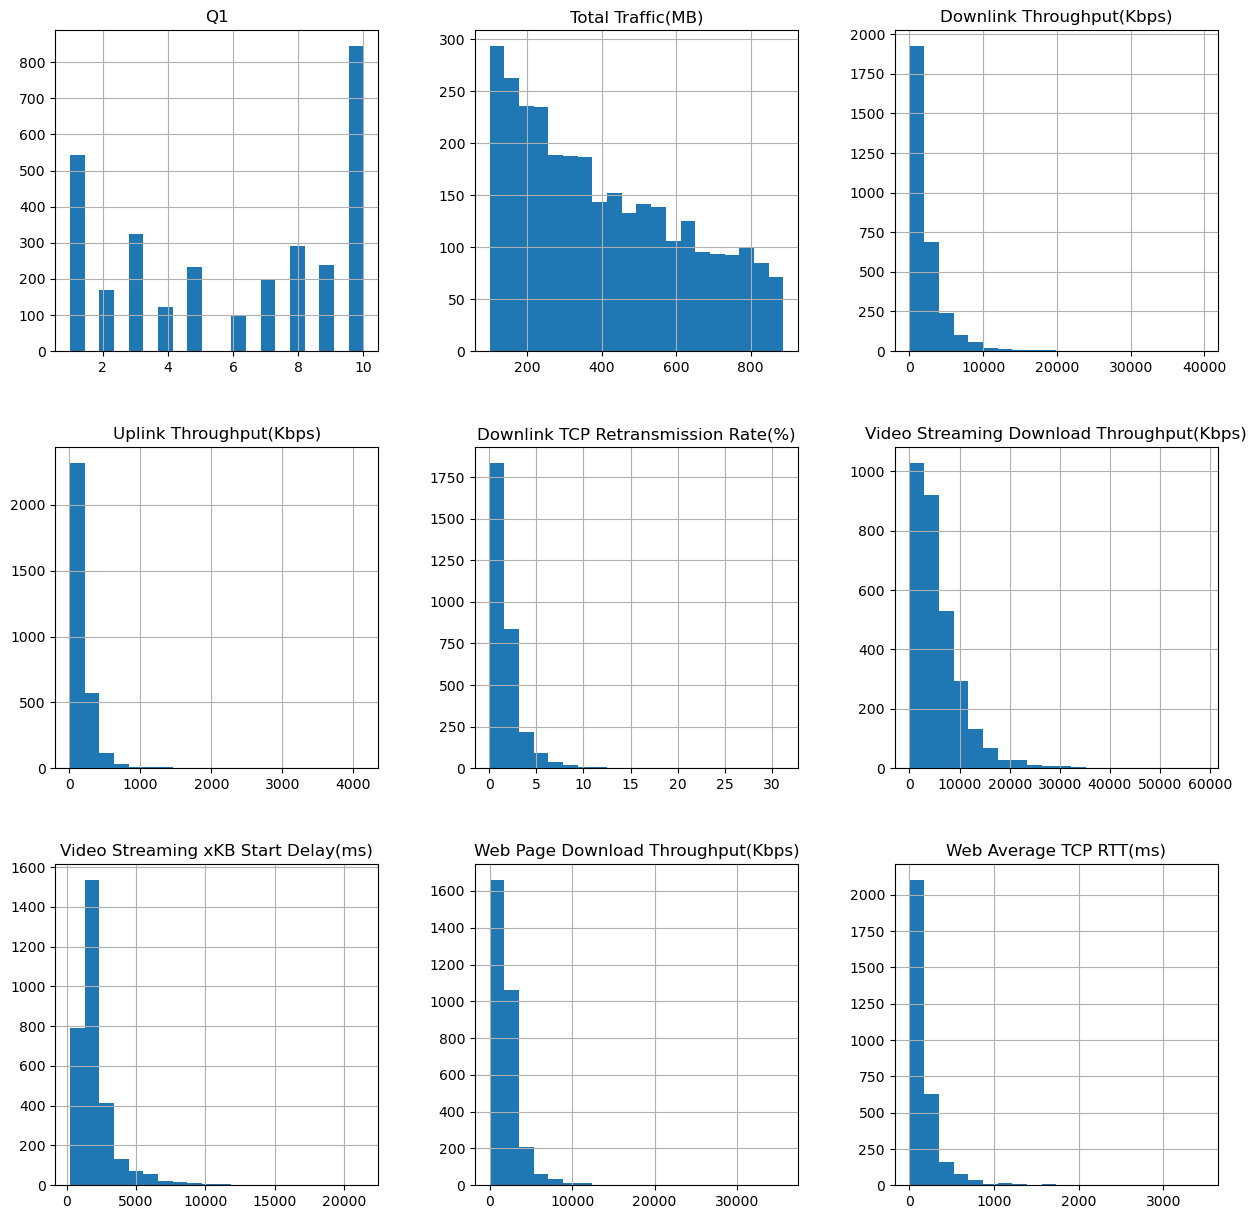

In [612]:
df.drop(columns=['user_id']).hist(figsize=(15,15), bins=20);

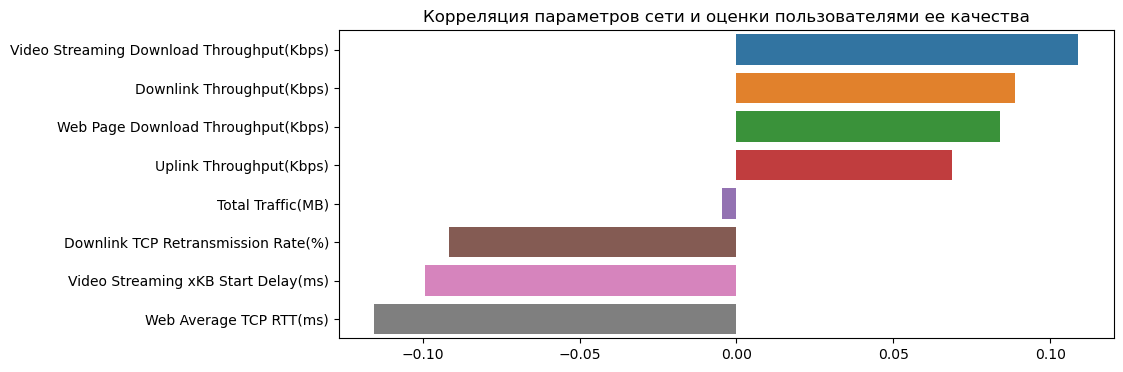

In [613]:
corr = df.drop(columns=['user_id', 'Q1']).corrwith(df.Q1).sort_values(ascending=False)
plot = sns.barplot(y=corr.index, x=corr)
plot.figure.set_size_inches(10,4)
plt.title('Корреляция параметров сети и оценки пользователями ее качества');

In [615]:
df['loyal'] = df.Q1.apply(lambda x : True if x in (10, 9) else False)
df.loyal.value_counts()

False    1984
True     1084
Name: loyal, dtype: int64

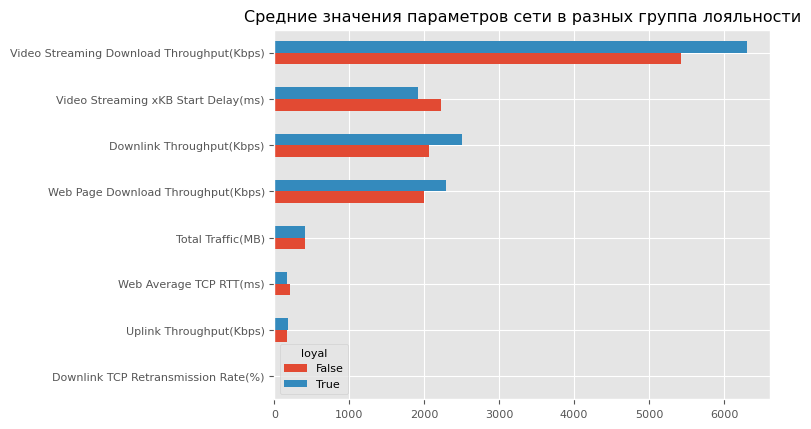

In [779]:
df.drop(columns=['user_id', 'Q1']).groupby('loyal')\
    .mean()\
    .transpose()\
    .sort_values(by=[0, 1])\
    .plot.barh(title= 'Средние значения параметров сети в разных группа лояльности');

Самыми популярными ответами на первый звонок являются оценки качеством сети - 10 и 1.
При этом число лояльных пользователей (давших наивысшую оценку 10 или 9) и остальных: 1084/1984.

Распределения параметров сети не являются нормальными и слабо коррелированы с ответом на первый звонок, при этом в большинстве из них есть сильные выбросы

Лояльные пользователи в среднем имели более высокие:
- скорость загрузки потокового видео
- среднюю скорость «к абоненту»
- скорость загрузки web-страниц через браузер

In [618]:
# s = df.Q1.value_counts().sort_values(ascending=False)
# ax = sns.barplot(x=s.index, y=s.values, order=s.index)
# patches = ax.patches
# percentage = round(df.Q1.value_counts()/df.Q1.count() * 100, 2).values
# for i in range(len(patches)):
#     x = patches[i].get_x() + patches[i].get_width()/2
#     y = patches[i].get_height() + 10
#     ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
# plt.title('Распределение оценок пользователей')
# plt.show()

Анализ результатов второго звонка. Согласно алгоритму, лояльным пользователям не происходило повторного звонка. Посмотрим на результаты ответов на второй звонок

In [599]:
df['loyal'] = df.Q1.apply(lambda x : True if x in (10, 9) else False)
df[df.loyal == True].Q2.unique()

array([nan], dtype=object)

In [600]:
df.Q2.unique()

array([nan, '4', '3', '2, 3, 4', '4, 5', '1, 3, 4', '1, 3, 4, 5', '1, 3',
       '3, 4', '1, 2', '3, 5', '1', '7', '1, 4', '1, 2, 3, 4, 5', '2, 3',
       '1, 2, 3, 4', '2, 3, 4, 5', '3, 4, 5', '1, 2, 5', '1, 5',
       '1, 2, 4', '6', '1, 4, 5', '1, 2, 3', '2, 5', '2, 4, 5', '1, 2, 7',
       '5', '2', '1, 2, 3, 4, 5, 6', '0, 1, 7', '4, 7', '1, 4, 7', '0, 3',
       '1, 3, 4, 5, 7', '3, 7', '1, 3, 4, 7', '3, 4, 5, 7', '2, 4',
       '5, 6', '1, 2, 3, 5', '1, 3, 5', '1, 2, 34', '1, 2, 4, 5',
       '0, 05, 2, 27, 7', '1, 3, 7', '3, 4, 7', '1, 2, 3, 4, 7', '10',
       '0', '1, 2, 3, 7'], dtype=object)

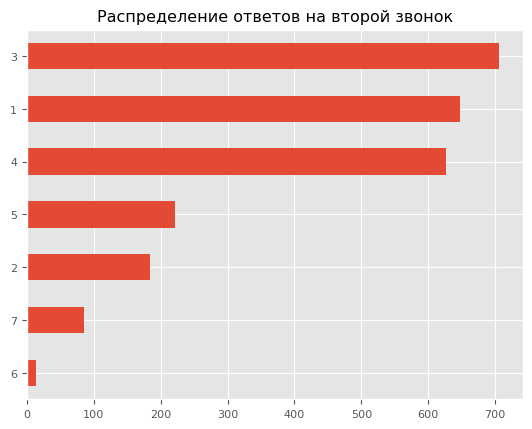

In [756]:
def Q2_score_count(col, score):
    return True if str(score) in str(col) else False

dfQ2 = df[df.loyal == False]
q2_count = []
for i in range(1, 8):
      q2_count.append(sum(dfQ2.Q2.apply(lambda x : Q2_score_count(x, i)))  )
q2_count = pd.Series(q2_count, index=range(1,8)).sort_values(ascending=True)
q2_count.plot.barh(title='Распределение ответов на второй звонок');

Самыми частыми причинами низкой оценки качества сети были: 
- Плохое качество связи в зданиях
- недозвоны и обрывы в звонках
- медленный мобильный интернет

#  A/B тестирование

Проведем несколько тестов для выделенных метрик и посмотрим оказывают ли они эффект на лояльность пользователя

## Video Streaming Download Throughput (скорость загрузки потокового видео)

Посмотрим есть ли статистически значимая разница в скорости загрузки потокового видео между лояльными и нелояльными пользователями.

H0 : разницы параметра между группами нет

H1 : в лояльной группе параметр выше

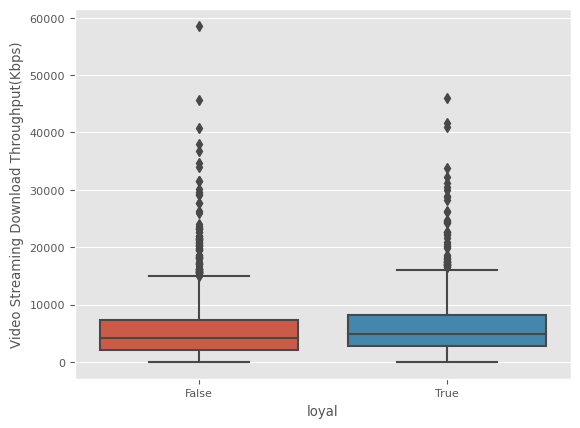

In [766]:
sns.boxplot(x='loyal', y='Video Streaming Download Throughput(Kbps)', data=df);

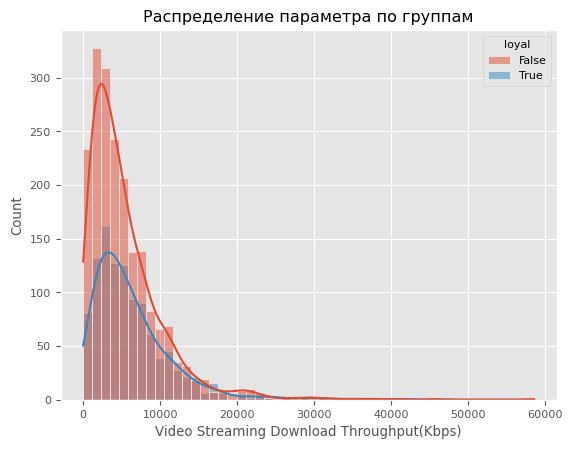

In [789]:
sns.histplot(data=df, x=df['Video Streaming Download Throughput(Kbps)'], hue='loyal', kde=True, common_norm=False, bins=50);
plt.title('Распределение параметра по группам');

In [768]:
df.groupby('loyal', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Video Streaming Download Throughput(Kbps)' : ['mean', 'median']
    })

loyal user_id Video Streaming Download Throughput(Kbps)         
           count                                      mean   median
0  False    1984                               5419.198054  4100.89
1   True    1084                               6303.191808  4934.91

In [854]:
print('Шапиро-Уилк для лояльной группы:\t',
      st.shapiro(df.query('loyal == True')['Video Streaming Download Throughput(Kbps)'].sample(1000)),
      '\nШапиро-Уилк для нелояльной группы:\t',
      st.shapiro(df.query('loyal == False')['Video Streaming Download Throughput(Kbps)'].sample(1000))
     )

Шапиро-Уилк для лояльной группы:	 ShapiroResult(statistic=0.8132609724998474, pvalue=1.743779600950836e-32) 
Шапиро-Уилк для нелояльной группы:	 ShapiroResult(statistic=0.8077576160430908, pvalue=7.393733835713444e-33)


Поскольку распределение не является нормальным и есть сильные выбросы применим непараметрический критерий Манна-Уитни

In [876]:
st.mannwhitneyu(
    df.query('loyal == True')['Video Streaming Download Throughput(Kbps)'],
    df.query('loyal == False')['Video Streaming Download Throughput(Kbps)'],
    alternative='greater'
    )

MannwhitneyuResult(statistic=1213833.0, pvalue=1.75587741348218e-09)

Проведем медианный bootstrap

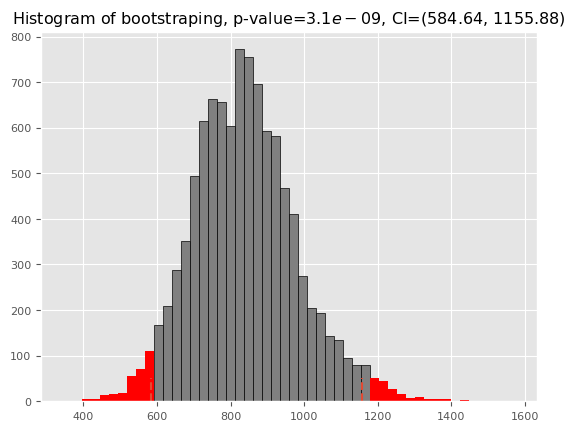

In [893]:
boot, pvalue, ci = bootstrap(
    df.query('loyal == True')['Video Streaming Download Throughput(Kbps)'],
    df.query('loyal == False')['Video Streaming Download Throughput(Kbps)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

При уровне доверия 5%  оба **теста показали статистически значимую разницу**, pvalue < 0.05 и доверительный интервал не включает нуль

----

Некоторые пользователи при ответе на второй звонок указывали причиной низкой оценки медленную загрузку видео, проверим, есть ли разница скорости закрузки потокового видео в группах, помечающих такой ответ и не помечающих

H0: параметры скорости одинаковые

H1: в помечающей группе параметр ниже

In [835]:
df5 = dfQ2.copy()
df5['mark_5'] = dfQ2.Q2.apply(lambda x : Q2_score_count(x, 5))

In [836]:
df5.drop(columns=['user_id', 'Q1', 'mark_5']).corrwith(df5.mark_5)

Total Traffic(MB)                            0.026024
Downlink Throughput(Kbps)                   -0.095592
Uplink Throughput(Kbps)                     -0.071115
Downlink TCP Retransmission Rate(%)          0.095537
Video Streaming Download Throughput(Kbps)   -0.127068
Video Streaming xKB Start Delay(ms)          0.006962
Web Page Download Throughput(Kbps)          -0.098876
Web Average TCP RTT(ms)                      0.083724
loyal                                             NaN
dtype: float64

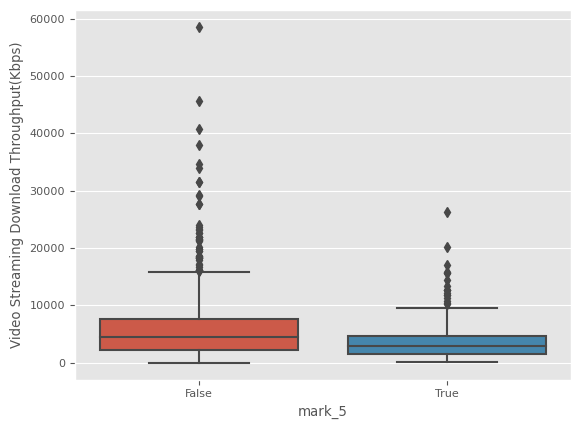

In [812]:
sns.boxplot(x='mark_5', y='Video Streaming Download Throughput(Kbps)', data=df5);

In [814]:
df5.groupby('mark_5', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Video Streaming Download Throughput(Kbps)' : ['mean', 'median']
    })

mark_5 user_id Video Streaming Download Throughput(Kbps)          
           count                                      mean    median
0  False    1093                               5731.583870  4441.680
1   True     222                               3950.257072  2927.745

Растределение не нормально, есть выбросы, применим непараметрические тесты:

In [881]:
st.mannwhitneyu(
    df5.query('mark_5 == True')['Video Streaming Download Throughput(Kbps)'],
    df5.query('mark_5 == False')['Video Streaming Download Throughput(Kbps)'],
    alternative='less'
    )

MannwhitneyuResult(statistic=92181.0, pvalue=8.059163042421061e-09)

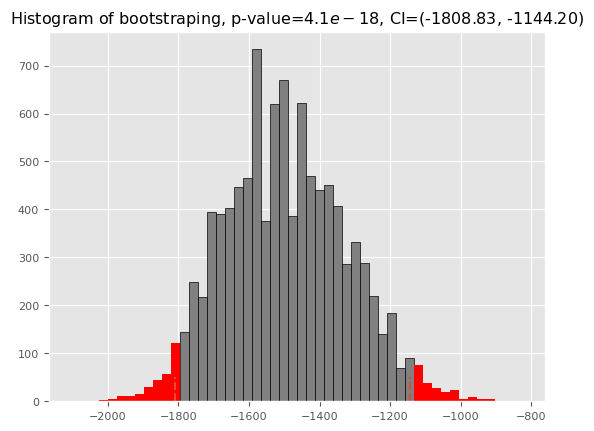

In [894]:
boot, pvalue, ci = bootstrap(
    df5.query('mark_5 == True')['Video Streaming Download Throughput(Kbps)'],
    df5.query('mark_5 == False')['Video Streaming Download Throughput(Kbps)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

Оба теста показали статистически значимую разницу

## Downlink Throughput(Kbps) (средняя скорость к абоненту)

Посмотрим есть ли статистически значимая разница в средней скорости «к абоненту» между лояльными и нелояльными пользователями.

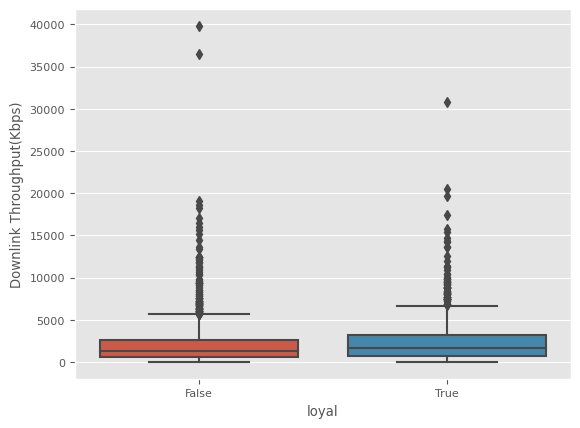

In [763]:
sns.boxplot(x='loyal', y='Downlink Throughput(Kbps)', data=df);

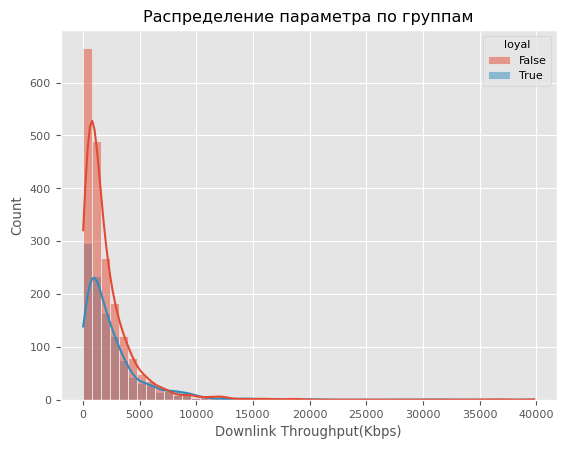

In [762]:
sns.histplot(data=df, x=df['Downlink Throughput(Kbps)'], hue='loyal', kde=True, common_norm=False, bins=50);
plt.title('Распределение параметра по группам');

In [905]:
df.groupby('loyal', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Downlink Throughput(Kbps)' : ['mean', 'median']
    })

loyal user_id Downlink Throughput(Kbps)         
           count                      mean   median
0  False    1984               2055.528579  1289.77
1   True    1084               2506.016900  1641.36

In [647]:
print('Шапиро-Уилк для лояльной группы:\t',
      st.shapiro(df.query('loyal == True')['Downlink Throughput(Kbps)'].sample(1000)),
      '\nШапиро-Уилк для нелояльной группы:\t',
      st.shapiro(df.query('loyal == False')['Downlink Throughput(Kbps)'].sample(1000)) 
     )

Шапиро-Уилк для лояльной группы:	 ShapiroResult(statistic=0.7700240612030029, pvalue=3.3133506590115455e-35) 
Шапиро-Уилк для нелояльной группы:	 ShapiroResult(statistic=0.6095318794250488, pvalue=1.2205309624269157e-42)


Поскольку распределение не является нормальным и есть сильные выбросы применим непараметрический критерий Манна-Уитни

In [911]:
st.mannwhitneyu(
    df.query('loyal == True')['Downlink Throughput(Kbps)'],
    df.query('loyal == False')['Downlink Throughput(Kbps)'],
    alternative='greater'
    )

MannwhitneyuResult(statistic=1204478.5, pvalue=1.8268367831040194e-08)

p-value $< 0.05$, **тест дал статистически значимые различия**

Проведем медианный bootstrap

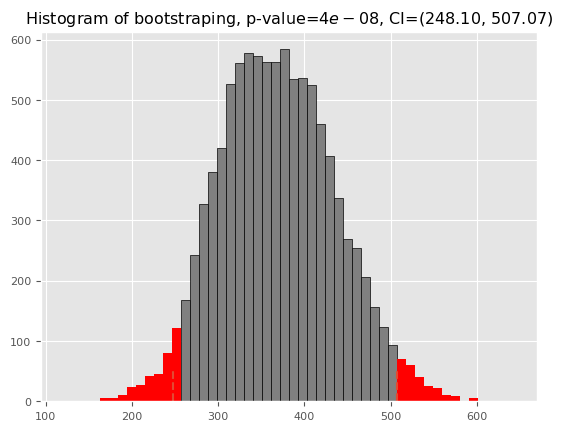

In [897]:
boot, pvalue, ci = bootstrap(
    df.query('loyal == True')['Downlink Throughput(Kbps)'],
    df.query('loyal == False')['Downlink Throughput(Kbps)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

p-value < 0.05 и доверительный интервал не покрывает 0. **Тест показал статистически значимую разницу параметра в группах.**

---

Некоторые пользователи при ответе на второй звонок указывали причиной плохое качество связи в зданиях, проверим, есть ли разница в средней скорости к абоненту в группах, помечающих такой ответ и не помечающих

H0: параметры скорости одинаковые

H1: в помечающей группе параметр ниже

In [898]:
df3 = dfQ2.copy()
df3['mark_3'] = dfQ2.Q2.apply(lambda x : Q2_score_count(x, 3))

In [899]:
df3.drop(columns=['user_id', 'Q1', 'mark_3']).corrwith(df3.mark_3)

Total Traffic(MB)                           -0.019161
Downlink Throughput(Kbps)                   -0.042235
Uplink Throughput(Kbps)                     -0.025079
Downlink TCP Retransmission Rate(%)          0.007560
Video Streaming Download Throughput(Kbps)   -0.039420
Video Streaming xKB Start Delay(ms)         -0.030038
Web Page Download Throughput(Kbps)          -0.006800
Web Average TCP RTT(ms)                     -0.030713
loyal                                             NaN
dtype: float64

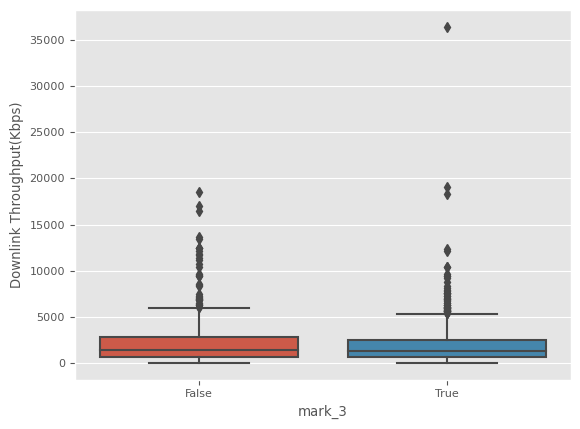

In [901]:
sns.boxplot(x='mark_3', y='Downlink Throughput(Kbps)', data=df3);

In [902]:
df3.groupby('mark_3', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Downlink Throughput(Kbps)' : ['mean', 'median']
    })

mark_3 user_id Downlink Throughput(Kbps)          
           count                      mean    median
0  False     609               2176.506010  1380.500
1   True     706               1966.825382  1259.615

In [903]:
st.mannwhitneyu(
    df3.query('mark_3 == True')['Downlink Throughput(Kbps)'],
    df3.query('mark_3 == False')['Downlink Throughput(Kbps)'],
    alternative='less'
    )

MannwhitneyuResult(statistic=204258.0, pvalue=0.05926917271098939)

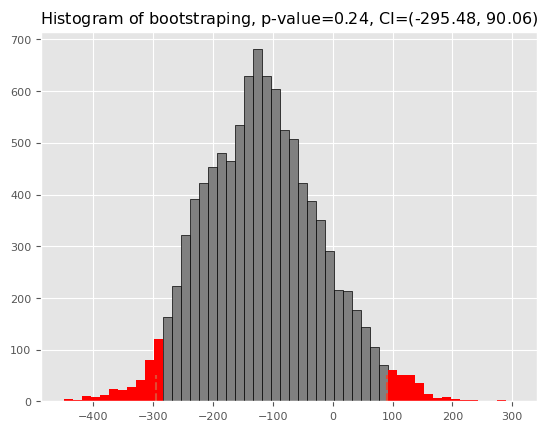

In [904]:
boot, pvalue, ci = bootstrap(
    df3.query('mark_3 == True')['Downlink Throughput(Kbps)'],
    df3.query('mark_3 == False')['Downlink Throughput(Kbps)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

При уровне доверия 5% оба теста **не показали статистической разницы** между группами, то есть вывод о том, что есть разница в скорости передачи к абоненту между теми, кто жаловался на плохую связь в зданиях и не жаловался, мы сделать не можем

---

Некоторые пользователи при ответе на второй звонок указывали причиной недозвоны и обрывы в звонках, проверим, есть ли разница в средней скорости к абоненту в группах, помечающих такой ответ и не помечающих

H0: средние одинаковые

H1: в помечающей группе параметр выше

In [914]:
df1 = dfQ2.copy()
df1['mark_1'] = dfQ2.Q2.apply(lambda x : Q2_score_count(x, 1))

In [915]:
df3.drop(columns=['user_id', 'Q1', 'mark_3']).corrwith(df3.mark_3)

Total Traffic(MB)                           -0.019161
Downlink Throughput(Kbps)                   -0.042235
Uplink Throughput(Kbps)                     -0.025079
Downlink TCP Retransmission Rate(%)          0.007560
Video Streaming Download Throughput(Kbps)   -0.039420
Video Streaming xKB Start Delay(ms)         -0.030038
Web Page Download Throughput(Kbps)          -0.006800
Web Average TCP RTT(ms)                     -0.030713
loyal                                             NaN
dtype: float64

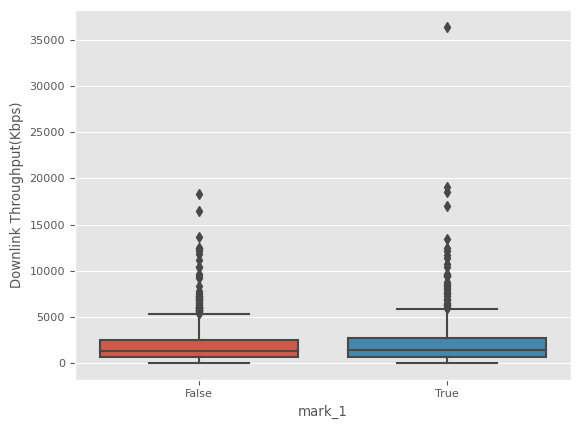

In [916]:
sns.boxplot(x='mark_1', y='Downlink Throughput(Kbps)', data=df1);

In [917]:
df1.groupby('mark_1', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Downlink Throughput(Kbps)' : ['mean', 'median']
    })

mark_1 user_id Downlink Throughput(Kbps)         
           count                      mean   median
0  False     667               1990.497781  1239.92
1   True     648               2139.519846  1350.35

In [920]:
st.mannwhitneyu(
    df1.query('mark_1 == True')['Downlink Throughput(Kbps)'],
    df1.query('mark_1 == False')['Downlink Throughput(Kbps)'],
    alternative='greater'
    )

MannwhitneyuResult(statistic=221537.5, pvalue=0.21518601153938882)

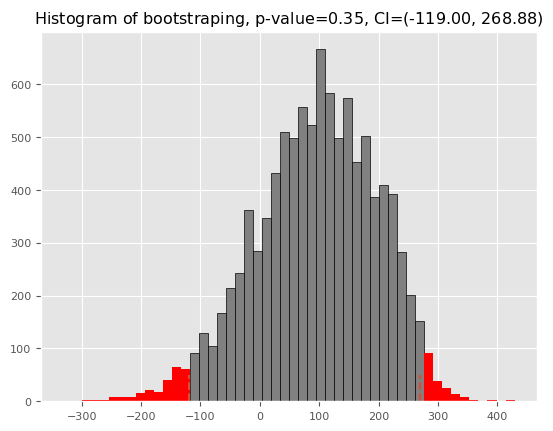

In [921]:
boot, pvalue, ci = bootstrap(
    df1.query('mark_1 == True')['Downlink Throughput(Kbps)'],
    df1.query('mark_1 == False')['Downlink Throughput(Kbps)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

pvalue обоих тестов сильно выше 5,10%, оба теста **не показали статистически значимой разницы** недовзвонов в группах, так что мы не можем сделать вывод, что число средняя скорость к абоненту значимо отличается в группах, кто пометил и нет проблему с недозвонами

## Video Streaming xKB Start Delay(ms) (задержка старта видео)

Посмотрим есть ли статистически значимая разница параметра в лояльных и не лояльных группах

H0: параметры не различаются

H1: в лояльной группе параметр ниже 

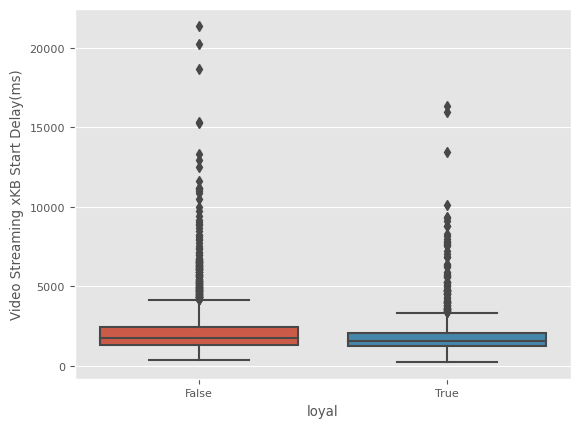

In [774]:
sns.boxplot(x='loyal', y='Video Streaming xKB Start Delay(ms)', data=df);

In [775]:
df.groupby('loyal', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Video Streaming xKB Start Delay(ms)' : ['mean', 'median']
    })

loyal user_id Video Streaming xKB Start Delay(ms)        
           count                                mean  median
0  False    1984                         2216.721270  1724.5
1   True    1084                         1919.189114  1552.0

In [926]:
st.mannwhitneyu(
    df.query('loyal == True')['Video Streaming xKB Start Delay(ms)'],
    df.query('loyal == False')['Video Streaming xKB Start Delay(ms)'],
    alternative='less'
    )

MannwhitneyuResult(statistic=911225.0, pvalue=1.305981018025675e-12)

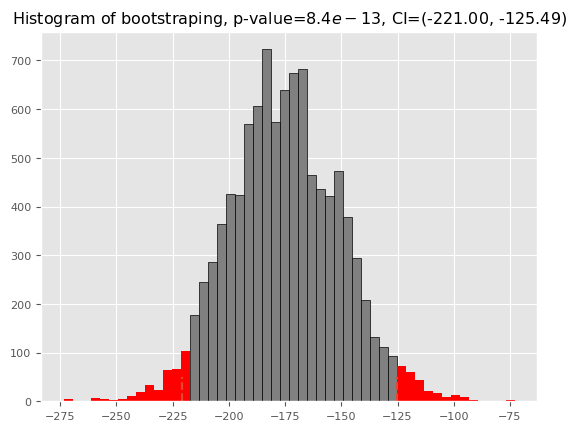

In [924]:
boot, pvalue, ci = bootstrap(
    df.query('loyal == True')['Video Streaming xKB Start Delay(ms)'],
    df.query('loyal == False')['Video Streaming xKB Start Delay(ms)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

оба теста показали **статистически значимую разницу** с уровнем доверия 5%, то есть мы может отвергнуть гипотезу о неразличимости задержки старта видео и лояльностью пользователя

----

Посмотрим есть ли разниц в показатели задержки видео и жалоой пользователей на медленную загрузку видео

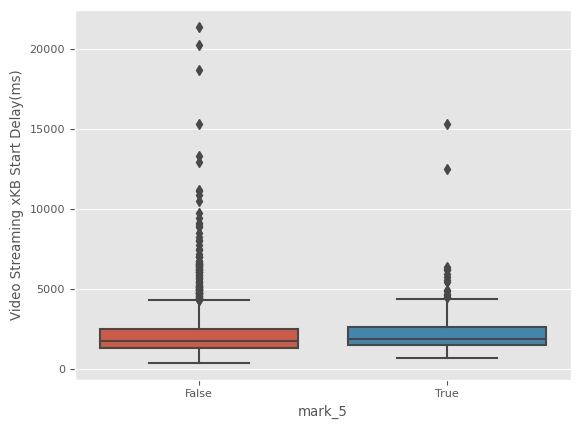

In [927]:
sns.boxplot(x='mark_5', y='Video Streaming xKB Start Delay(ms)', data=df5);

In [928]:
df5.groupby('mark_5', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Video Streaming xKB Start Delay(ms)' : ['mean', 'median']
    })

mark_5 user_id Video Streaming xKB Start Delay(ms)        
           count                                mean  median
0  False    1093                         2271.993596  1722.0
1   True     222                         2305.743243  1863.0

In [930]:
st.mannwhitneyu(
    df5.query('mark_5 == True')['Video Streaming xKB Start Delay(ms)'],
    df5.query('mark_5 == False')['Video Streaming xKB Start Delay(ms)'],
    alternative='greater'
    )

MannwhitneyuResult(statistic=133817.0, pvalue=0.007719297344432305)

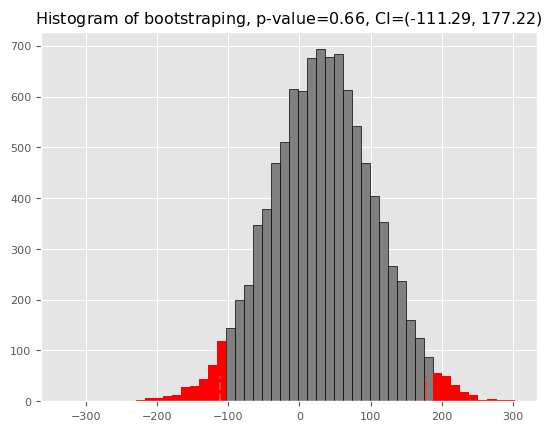

In [934]:
boot, pvalue, ci = bootstrap(
    df5.query('mark_5 == True')['Video Streaming xKB Start Delay(ms)'],
    df5.query('mark_5 == False')['Video Streaming xKB Start Delay(ms)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.mean)

Получили противоречащие результаты тестов, выборки сильно несбалансированы. Можно сделать вывод о недостаточности данных

## Web Page Download Throughput(Kbps) (скорость загрузки web-страниц через браузер)

Посмотрим на различия в скорости загрузки веб-страниц между лояльными и не лояльными пользователями

H0: разницы в параметрах нет

H1: в лояльной группе показатель выше

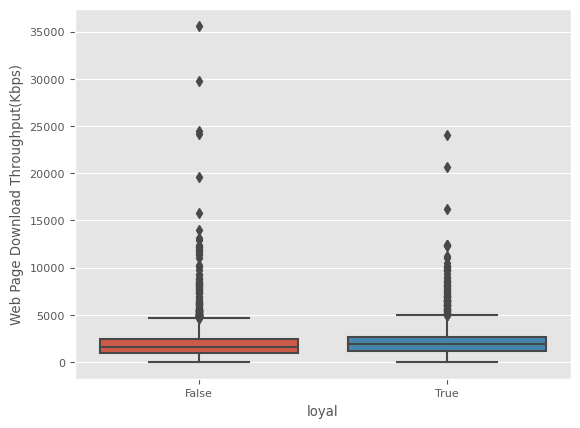

In [937]:
sns.boxplot(x='loyal', y='Web Page Download Throughput(Kbps)', data=df);

In [938]:
df.groupby('loyal', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Web Page Download Throughput(Kbps)' : ['mean', 'median']
    })

loyal user_id Web Page Download Throughput(Kbps)          
           count                               mean    median
0  False    1984                        1988.860126  1584.825
1   True    1084                        2290.297491  1848.650

In [936]:
st.mannwhitneyu(
    df.query('loyal == True')['Web Page Download Throughput(Kbps)'],
    df.query('loyal == False')['Web Page Download Throughput(Kbps)'],
    alternative='greater'
    )

MannwhitneyuResult(statistic=1224701.0, pvalue=9.507679165865449e-11)

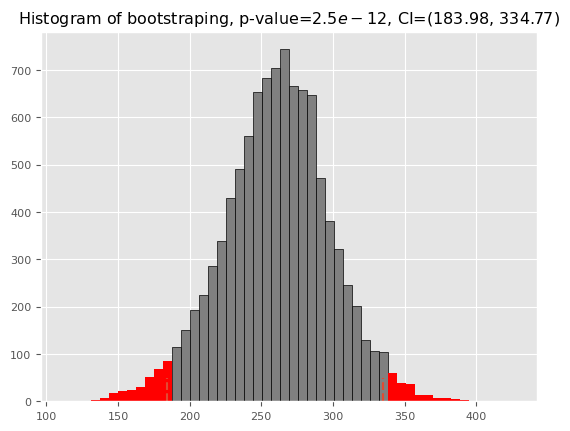

In [941]:
boot, pvalue, ci = bootstrap(
    df.query('loyal == True')['Web Page Download Throughput(Kbps)'],
    df.query('loyal == False')['Web Page Download Throughput(Kbps)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

Тесты показали **статистически значимые различия** в скорости загрузки веб страниц у лояльных и не лояльных пользователей при уровне значимости 5%

---

Посмотрим связь между скоростью загрузки веб страниц и жалобами пользователей на низкий мобильный интернет

H0: параметры не различаются

H1: в группе с жалобами показатель ниже

In [942]:
df4 = dfQ2.copy()
df4['mark_4'] = dfQ2.Q2.apply(lambda x : Q2_score_count(x, 4))

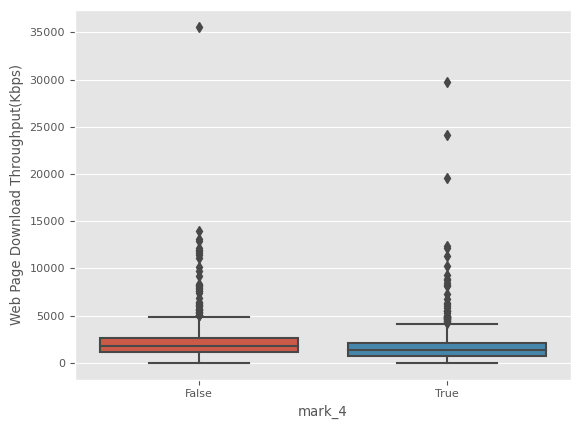

In [944]:
sns.boxplot(x='mark_4', y='Web Page Download Throughput(Kbps)', data=df4);

In [945]:
df4.groupby('mark_4', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Web Page Download Throughput(Kbps)' : ['mean', 'median']
    })

mark_4 user_id Web Page Download Throughput(Kbps)          
           count                               mean    median
0  False     689                        2211.845457  1743.870
1   True     626                        1821.258498  1334.915

In [947]:
st.mannwhitneyu(
    df4.query('mark_4 == True')['Web Page Download Throughput(Kbps)'],
    df4.query('mark_4 == False')['Web Page Download Throughput(Kbps)'],
    alternative='less'
    )

MannwhitneyuResult(statistic=171517.5, pvalue=6.911401901988527e-11)

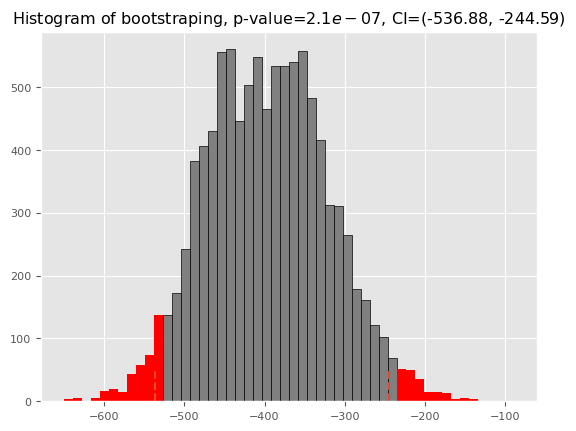

In [949]:
boot, pvalue, ci = bootstrap(
    df4.query('mark_4 == True')['Web Page Download Throughput(Kbps)'],
    df4.query('mark_4 == False')['Web Page Download Throughput(Kbps)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

**Тесты показали статистически значимые различия**

## Web Average TCP RTT(ms) (пинг при просмотре web-страниц)

Посмотрим на различия в пинге при просмотре веб-страниц между лояльными и не лояльными пользователями

H0: разницы в параметрах нет

H1: в лояльной группе показатель ниже

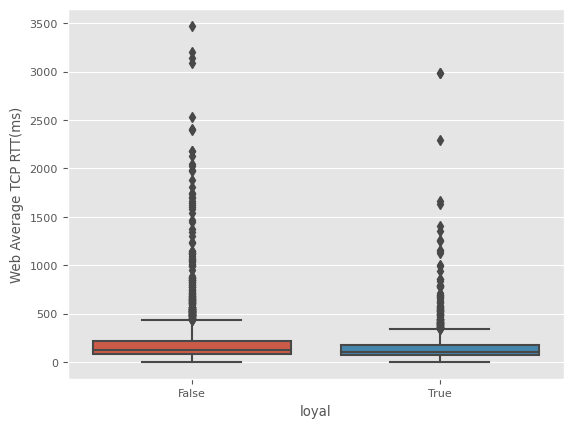

In [785]:
sns.boxplot(x='loyal', y='Web Average TCP RTT(ms)', data=df);

In [950]:
df.groupby('loyal', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Web Average TCP RTT(ms)' : ['mean', 'median']
    })

loyal user_id Web Average TCP RTT(ms)       
           count                    mean median
0  False    1984              208.854839  126.5
1   True    1084              167.376384  105.0

In [951]:
st.mannwhitneyu(
    df.query('loyal == True')['Web Average TCP RTT(ms)'],
    df.query('loyal == False')['Web Average TCP RTT(ms)'],
    alternative='less'
    )

MannwhitneyuResult(statistic=937410.5, pvalue=2.0424159146309238e-09)

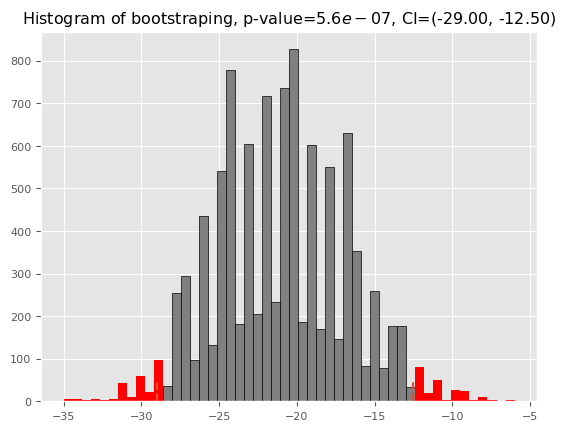

In [952]:
boot, pvalue, ci = bootstrap(
    df.query('loyal == True')['Web Average TCP RTT(ms)'],
    df.query('loyal == False')['Web Average TCP RTT(ms)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

**Тесты показали статистически значимые раличия**

----

Посмотрим связь между пингом при просмотре веб страниц и жалобами пользователей на низкий мобильный интернет

H0: параметры не различаются

H1: в группе с жалобами показатель ниже

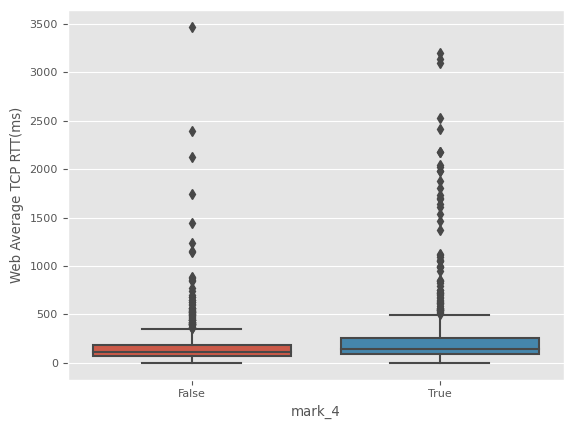

In [953]:
sns.boxplot(x='mark_4', y='Web Average TCP RTT(ms)', data=df4);

In [954]:
df4.groupby('mark_4', as_index=False)\
    .agg({
        'user_id' : 'count',
        'Web Average TCP RTT(ms)' : ['mean', 'median']
    })

mark_4 user_id Web Average TCP RTT(ms)       
           count                    mean median
0  False     689              175.352685  111.0
1   True     626              262.769968  144.0

In [956]:
st.mannwhitneyu(
    df4.query('mark_4 == True')['Web Average TCP RTT(ms)'],
    df4.query('mark_4 == False')['Web Average TCP RTT(ms)'],
    alternative='greater'
    )

MannwhitneyuResult(statistic=256350.5, pvalue=1.640614886037759e-09)

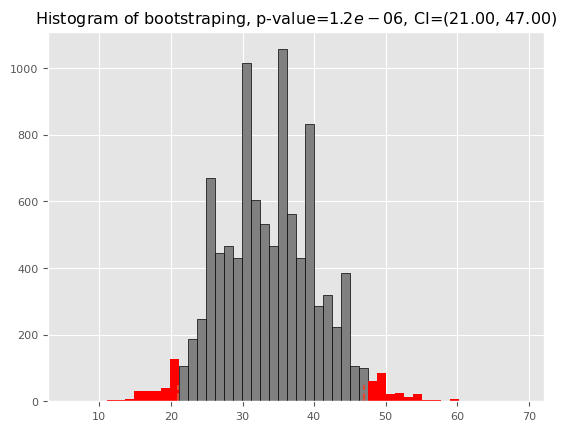

In [959]:
boot, pvalue, ci = bootstrap(
    df4.query('mark_4 == True')['Web Average TCP RTT(ms)'],
    df4.query('mark_4 == False')['Web Average TCP RTT(ms)'],
    alpha=0.95,
    n_boots=10000,
    statistic=np.median)

Тест показал статистически значиме различия при уровне доверия 5%. То есть мы отвергнуть гипотезу о том, что нет раличий в пинге между жалующимися на низкий мобильный интернет и не жалующимися

# Вывод

По результатам анализа можем сделать следующие выводы:


- Параметры сети (Web Average TCP RTT, Web Page Download Throughput, Video Streaming xKB Start Delay, Video Streaming Download Throughput, Downlink Throughput) и ответы на первый звонок явно не связаны


- Однако есть статистически значимые различия в этих показателях между лояльными(поставившими наивысшие оценки) и не лояльными пользователями. У лояльных пользователей показатели лучше

---

- Имеется связь между медленной загрузкой видео и скоростью загрузки потового видео


- Плохое качество связи в зданиях и недозвоны не имеют связи с средней скоростью к абоненту


- Медленный мобильный интернет имеет связь с пингом при просмотре веб-страниц и скоростью загруки веб-страниц через браузер